In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import snowflake.connector
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [15]:
# Connect to Snowflake
snowflake_connection = snowflake.connector.connect(
    user='SUSHMAMENGANI',
    password='Srinidhi7',
    account='elugxls-ox45694',
    warehouse='COMPUTE_WH',
    database='COVID19_EPIDEMIOLOGICAL_DATA',
    schema='public'
)


In [8]:
# SQL query to retrieve data from Snowflake
sql_query = """
    SELECT
    POSITIVE,
    NEGATIVE,
    DATE
FROM
    CDC_TESTING;
"""

In [9]:
# Read the data into a DataFrame
df = pd.read_sql_query(sql_query, snowflake_connection)

/var/folders/v_/7904q47n6bn5nm7byff92ml40000gn/T/ipykernel_3174/146402452.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, snowflake_connection)


In [10]:
# Fit ARIMA model
model = ARIMA(df['POSITIVE'], order=(1, 1, 1))  # Replace with appropriate order based on analysis
result = model.fit()

# Forecast future values
forecast_steps = 30  # Number of steps to forecast into the future
forecast = result.get_forecast(steps=forecast_steps)

# Extract forecasted values and corresponding dates
forecast_values = forecast.predicted_mean.values
forecast_dates = pd.date_range(start=df['DATE'].max() + timedelta(days=1), periods=forecast_steps)

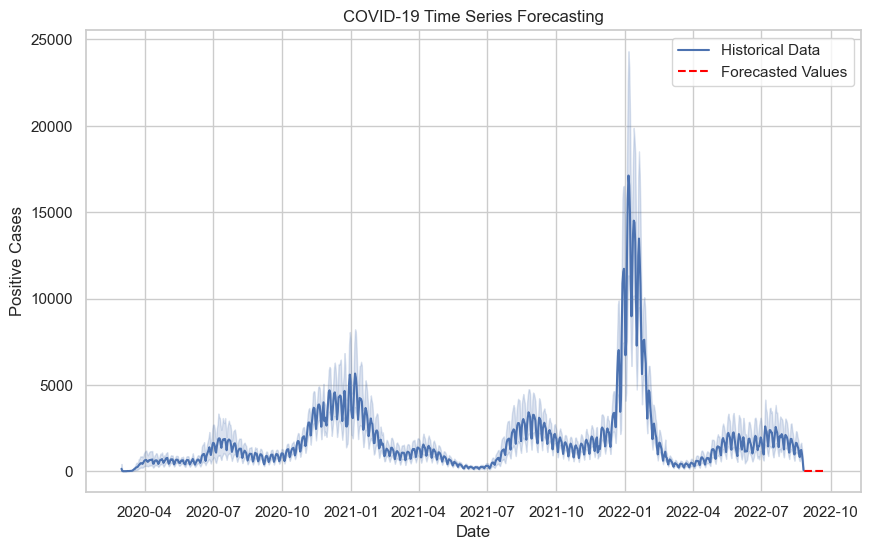

In [11]:
# Plotting the historical data and forecasted values using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot historical data
sns.lineplot(x=df['DATE'], y=df['POSITIVE'], label='Historical Data')

# Plot forecasted values
sns.lineplot(x=forecast_dates, y=forecast_values, label='Forecasted Values', linestyle='--', color='red')

plt.xlabel('Date')
plt.ylabel('Positive Cases')
plt.title('COVID-19 Time Series Forecasting')
plt.legend()
plt.show()

In [12]:
sql_query = """
    SELECT 
    COUNTRY_REGION, 
    DATE, 
    DEATHS, 
    CONFIRMED, 
    MORTALITY_RATE
FROM 
    JHU_DASHBOARD_COVID_19_GLOBAL;
"""



In [17]:
with snowflake_connection.cursor() as cursor:
    cursor.execute(sql_query)
    result = cursor.fetchall()


In [ ]:
# Create a DataFrame from the query result
covid_data = pd.DataFrame(result, columns=["COUNTRY_REGION", "DATE", "DEATHS", "CONFIRMED", "MORTALITY_RATE"])

selected_country = "Colombia"

# Filter data for the selected country
selected_data = covid_data[covid_data["COUNTRY_REGION"] == selected_country]

# Select relevant columns for forecasting
forecast_data = selected_data[["DATE", "MORTALITY_RATE"]]
forecast_data.columns = ["ds", "y"]

# Convert 'ds' to datetime format
forecast_data["ds"] = pd.to_datetime(forecast_data["ds"])

In [ ]:


# Fit ARIMA model
model = ARIMA(forecast_data["y"], order=(1, 1, 1))  # Adjust order as needed
fit_model = model.fit()

# Forecast future values
future_steps = 30  
forecast_values = fit_model.forecast(steps=future_steps)

# Create a DataFrame for the forecast
forecast_dates = pd.date_range(start=forecast_data["ds"].max() + timedelta(days=1), periods=future_steps, freq="D")
forecast_df = pd.DataFrame({"ds": forecast_dates, "y": forecast_values})



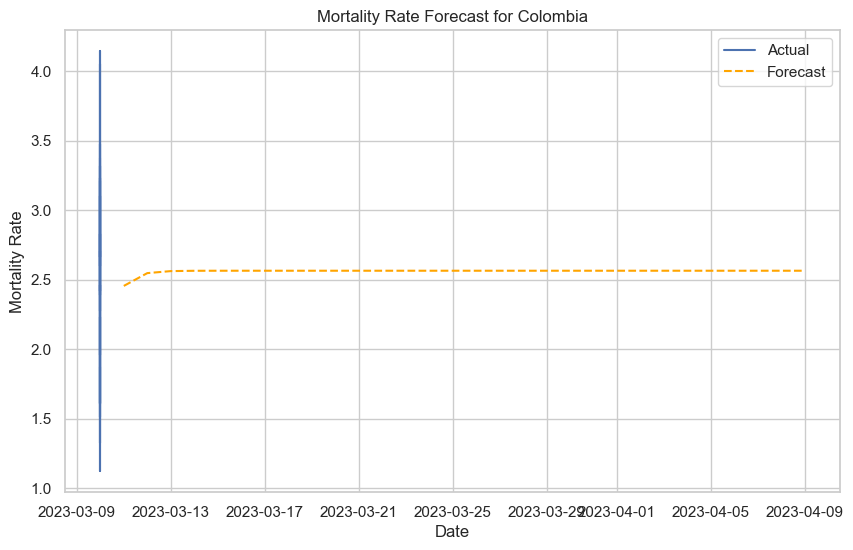

In [26]:
# Plot the actual data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(forecast_data["ds"], forecast_data["y"], label="Actual")
plt.plot(forecast_df["ds"], forecast_df["y"], label="Forecast", linestyle="--", color="orange")
plt.title(f'Mortality Rate Forecast for {selected_country}')
plt.xlabel('Date')
plt.ylabel('Mortality Rate')
plt.legend()
plt.show()


In [20]:
# SQL query 
sql_query = """
   SELECT
    COUNTRY_REGION,
    CASES,
    DEATHS
FROM
    ECDC_GLOBAL;

"""


In [21]:
# Read the data into a DataFrame
df = pd.read_sql_query(sql_query, snowflake_connection)

/var/folders/v_/7904q47n6bn5nm7byff92ml40000gn/T/ipykernel_1805/146402452.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, snowflake_connection)


In [27]:
# One-hot encode 'COUNTRY_REGION'
df_encoded = pd.get_dummies(df, columns=['COUNTRY_REGION'])

# Selecting the  relevant features for clustering
X = df_encoded[['CASES', 'DEATHS']]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df_encoded['cluster'] = kmeans.fit_predict(X_scaled)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_encoded['pca1'] = X_pca[:, 0]
df_encoded['pca2'] = X_pca[:, 1]


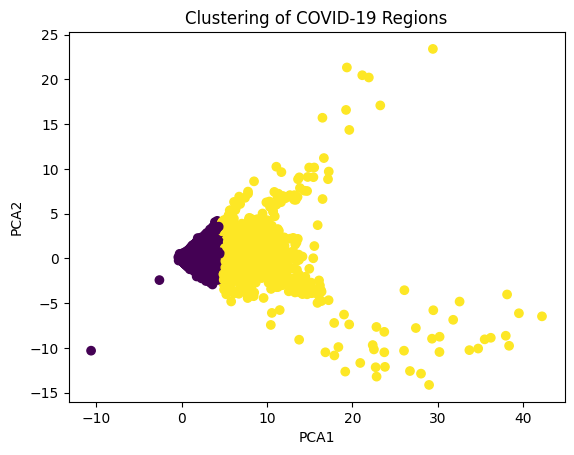

In [28]:

# Plotting the clustered data
plt.scatter(df_encoded['pca1'], df_encoded['pca2'], c=df_encoded['cluster'], cmap='viridis')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clustering of COVID-19 Regions')
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seagull as sg
import snowflake.connector
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Connect to Snowflake
snowflake_connection = snowflake.connector.connect(
    user='SUSHMAMENGANI',
    password='Srinidhi7',
    account='elugxls-ox45694',
    warehouse='COMPUTE_WH',
    database='COVID19_EPIDEMIOLOGICAL_DATA',
    schema='public'
)





sql_query = """
    SELECT 
    COUNTRY_REGION, 
    DATE, 
    DEATHS, 
    CONFIRMED, 
    MORTALITY_RATE
FROM 
    JHU_DASHBOARD_COVID_19_GLOBAL;
"""

df = pd.read_sql_query(sql_query, snowflake_connection)

selected_country = "Colombia"

# Filter data for the selected country
selected_data = covid_data[covid_data["country_region"] == selected_country]

# Select relevant columns for forecasting
forecast_data = selected_data[["date", "mortality_rate"]]
forecast_data.columns = ["ds", "y"]

# Convert 'ds' to datetime format
forecast_data["ds"] = pd.to_datetime(forecast_data["ds"])

# Fit ARIMA model
model = ARIMA(forecast_data["y"], order=(1, 1, 1))  # Adjust order as needed
fit_model = model.fit()

# Forecast future values
future_steps = 30  # Adjust as needed
forecast_values = fit_model.forecast(steps=future_steps)

# Create a DataFrame for the forecast
forecast_dates = pd.date_range(start=forecast_data["ds"].max() + timedelta(days=1), periods=future_steps, freq="D")
forecast_df = pd.DataFrame({"ds": forecast_dates, "y": forecast_values})

# Plot the actual data and the forecast
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(forecast_data["ds"], forecast_data["y"], label="Actual")
sns.lineplot(forecast_df["ds"], forecast_df["y"], label="Forecast", linestyle="--", color="orange")

# Add a title and axis labels
ax.set_title(f'Mortality Rate Forecast for India')
ax.set_xlabel('Date')
ax.set_ylabel('Mortality Rate')

# Add gridlines
ax.grid(True)

# Add a legend
ax.legend()

# Enhance the visualization with better colors and styling
sns.set_style("darkgrid")
sns.despine()

# Show the plot
plt.show()
